## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Please read the instructions carefully before starting the project.**

**Note**: If the free-tier GPU of Google Colab is not accessible (due to unavailability or exhaustion of daily limit or other reasons), the following steps can be taken:

1. Wait for 12-24 hours until the GPU is accessible again or the daily usage limits are reset.

2. Switch to a different Google account and resume working on the project from there.

3. Try using the CPU runtime:
    - To use the CPU runtime, click on *Runtime* => *Change runtime type* => *CPU* => *Save*
    - One can also click on the *Continue without GPU* option to switch to a CPU runtime (kindly refer to the snapshot below)
    - The instructions for running the code on the CPU are provided in the respective sections of the notebook.

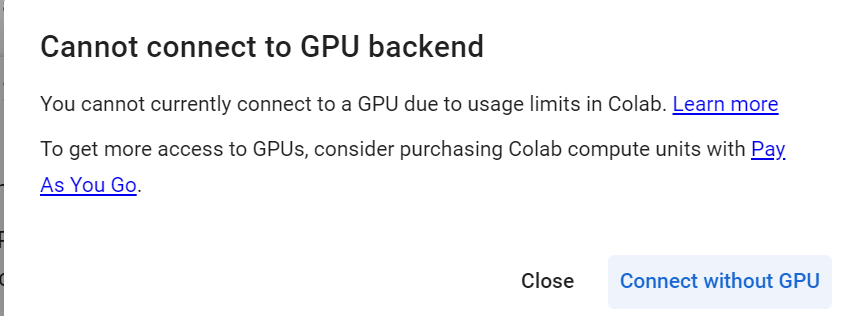

## **Installing and Importing Necessary Libraries**

In [107]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install -U sentence-transformers gensim transformers tqdm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 80.6 MB/s eta 0:00:00


In [108]:
# To manipulate and analyze data
import pandas as pd
import numpy as np

# To visualize data
import matplotlib.pyplot as plt
import seaborn as sns

# To used time-related functions
import time

# To parse JSON data
import json

# to use regular expressions for manipulating text data
import re


# to load the natural language toolkit
import nltk
nltk.download('stopwords')    # loading the stopwords
nltk.download('wordnet')    # loading the wordnet module that is used in stemming

# to remove common stop words
from nltk.corpus import stopwords

# to visualize text data using wordcloud
# from wordcloud import STOPWORDS

# to perform stemming
from nltk.stem.porter import PorterStemmer

# To build, tune, and evaluate ML models
#from sklearn.ensemble import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# To load/create word embeddings
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# To work with transformer models
import torch
from sentence_transformers import SentenceTransformer

# To implement progress bar related functionalities
from tqdm import tqdm
tqdm.pandas()

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## **Loading the dataset**

In [102]:
 #Code to mount the drive
 from google.colab import drive
 drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
# loading data into a pandas dataframe
stock_news = pd.read_csv("/content/drive/MyDrive/NLP Project/stock_news.csv")

In [110]:
# creating a copy of the data
stock = stock_news.copy()

## **Data Overview**

###Displaying the first 5 rows of the dataset

In [ ]:
stock.head(5)

Date                                               News       Open  \
0  2019-01-02   The tech sector experienced a significant dec...  41.740002   
1  2019-01-02   Apple lowered its fiscal Q1 revenue guidance ...  41.740002   
2  2019-01-02   Apple cut its fiscal first quarter revenue fo...  41.740002   
3  2019-01-02   This news article reports that yields on long...  41.740002   
4  2019-01-02   Apple's revenue warning led to a decline in U...  41.740002   

        High        Low      Close     Volume  Label  
0  42.244999  41.482498  40.246914  130672400     -1  
1  42.244999  41.482498  40.246914  130672400     -1  
2  42.244999  41.482498  40.246914  130672400     -1  
3  42.244999  41.482498  40.246914  130672400     -1  
4  42.244999  41.482498  40.246914  130672400     -1

**Observations**

 * Here, a sentiment value of **-1 is negative**,**0 is neutral**  and **1 is positive**.

###Understanding the shape of the dataset

In [ ]:
stock.shape

(349, 8)

**Observations**

* There are 349 rows and 8 columns in given dataset

###Checking the data types of the columns

In [ ]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


**Observations**

* The date column is object data type it should be datetime data type

In [ ]:
stock['Date'] = pd.to_datetime(stock['Date'])  # to convert the 'Date' column in the 'stock' DataFrame to datetime format.

###Checking the statistical summary

In [ ]:
stock.describe().T

count                           mean                  min  \
Date      349  2019-02-16 16:05:30.085959936  2019-01-02 00:00:00   
Open    349.0                      46.229233            37.567501   
High    349.0                      46.700458            37.817501   
Low     349.0                      45.745394               37.305   
Close   349.0                      44.926317            36.254131   
Volume  349.0               128948236.103152           45448000.0   
Label   349.0                      -0.054441                 -1.0   

                        25%                  50%                  75%  \
Date    2019-01-14 00:00:00  2019-02-05 00:00:00  2019-03-22 00:00:00   
Open              41.740002            45.974998              50.7075   
High              42.244999            46.025002            50.849998   
Low               41.482498            45.639999              49.7775   
Close             40.246914            44.596924             49.11079   
Volume          103272000.0          115627200.0          151125200.0   
Label                  -1.0                  0.0                  0.0   

                        max              std  
Date    2019-04-30 00:00:00              NaN  
Open              66.817497         6.442817  
High                67.0625         6.507321  
Low               65.862503         6.391976  
Close             64.805229         6.398338  
Volume          244439200.0  43170314.918964  
Label                   1.0         0.715119

**Observations**

* The stock opens at an average price of $46.
* The stock close at an average price of 44 which is low than the opening price of stock.

###Checking the duplicate values

In [ ]:
stock.duplicated().sum()

0

**Observations**

* There are no duplicates in the data.

### Checking for missing values

In [ ]:
stock.isnull().sum()

Date      0
News      0
Open      0
High      0
Low       0
Close     0
Volume    0
Label     0
dtype: int64

**Observations**

* There are no missing values in the dataset.

## **Exploratory Data Analysis**

### Univariate Analysis

* Distribution of individual variables
* Compute and check the distribution of the length of news content

#### Observations on Label

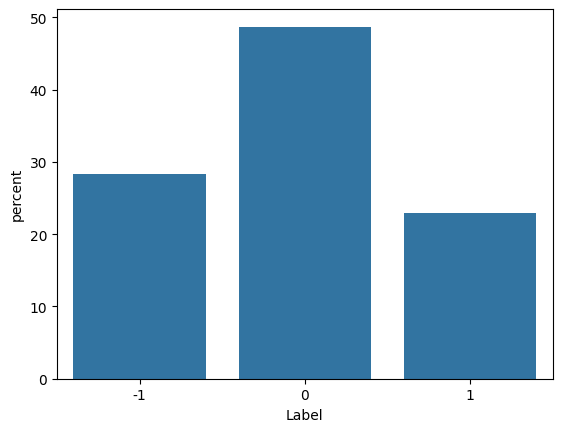

In [111]:
sns.countplot(data=stock, x="Label", stat="percent");

**Observations**

* Data is imbalanced.
* There are more neutral sentiments as compared to positive/negative sentiments

#### Density Plot of Price (Open,High,Low,Close)

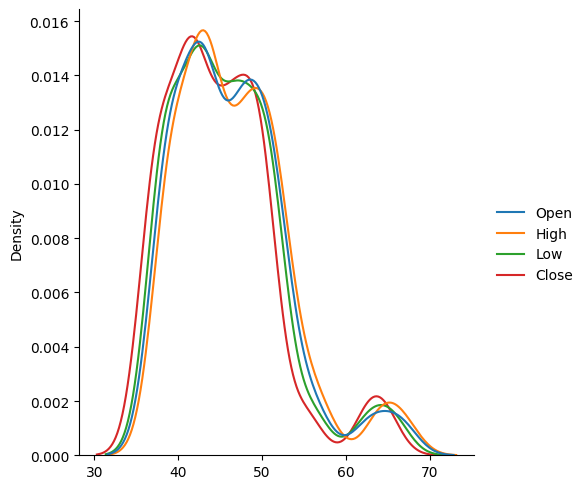

In [112]:
sns.displot(data=stock[['Open','High','Low','Close']], kind="kde", palette="tab10");

**Observations**

* The stock opens at an average price of $46.
* The stock close at an average price of 44 which is low than the opening price of stock.

#### Observations on Volume

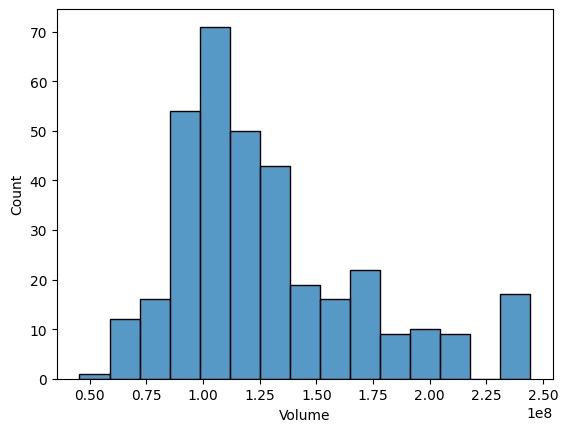

In [113]:
sns.histplot(stock, x='Volume');

**Observervation**
* The number of shares traded during the day is around 128948236.

#### Observations on News length

In [114]:
#Calculating the total number of words present in the news content.
stock['news_len'] = stock['News'].apply(lambda x: len(x.split(' ')))


stock['news_len'].describe()    #Complete the code to print the statistical summary for the news content length

count    349.000000
mean      49.312321
std        5.727770
min       19.000000
25%       46.000000
50%       50.000000
75%       53.000000
max       61.000000
Name: news_len, dtype: float64

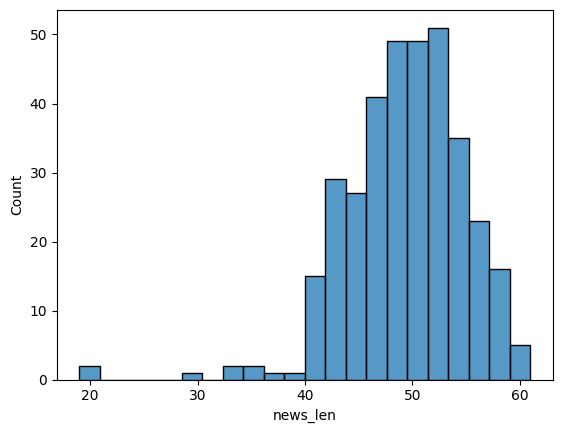

In [115]:
sns.histplot(data=stock,x='news_len');

**Observations**
* Most news are 50-60 word long

### Bivariate Analysis

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

#### Correlation

In [118]:
corr_matrix = stock.select_dtypes(include='number').corr()

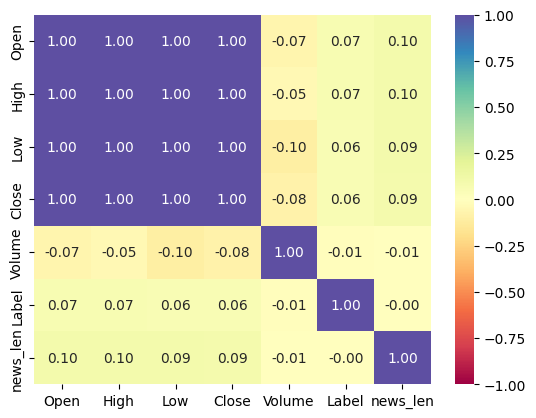

In [119]:
sns.heatmap(
    corr_matrix, annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
);

#### Label vs Price (Open, High, Low, Close)

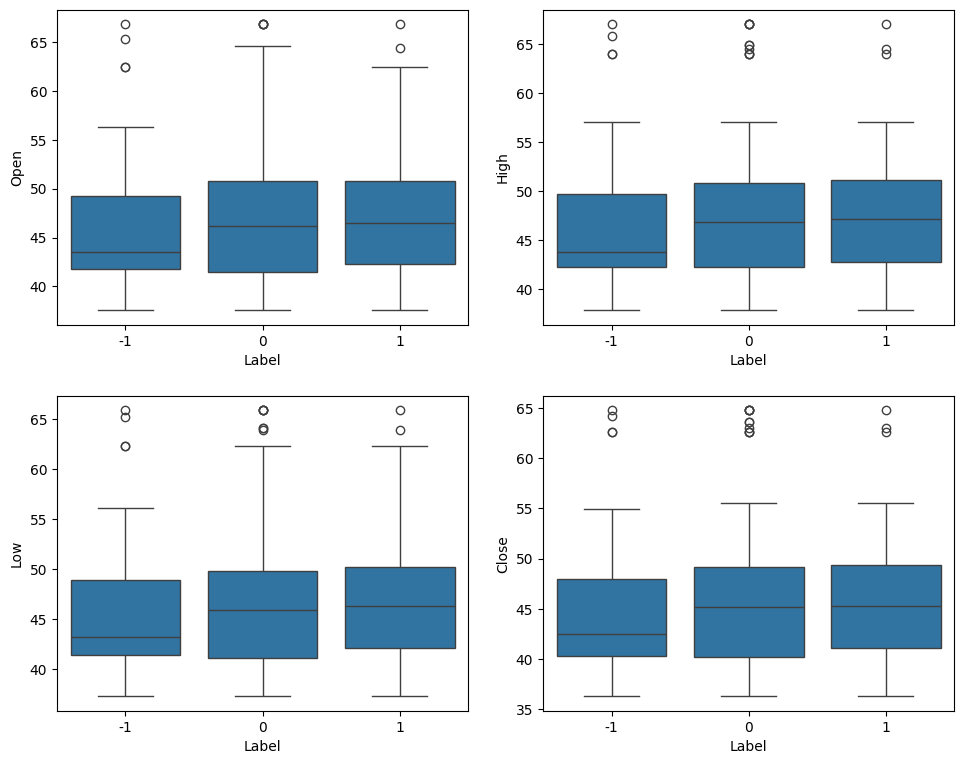

In [116]:
plt.figure(figsize=(10, 8))

for i, variable in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=stock, x="Label", y=variable)
    plt.tight_layout(pad=2)

plt.show()

**Observations**

* Market will open/close ~ high/low is directly impacted by sentiments in market.
* Market will open high and close high if sentiment is neutral.
* Market will open low and close low if sentiment is negative.
* Market will open high and close high if sentiment is positive.


#### Label vs Volume

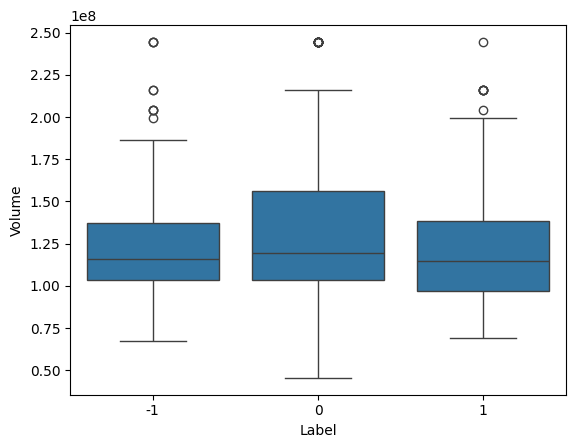

In [117]:
sns.boxplot(
    data=stock, x='Label', y='Volume'  # Complete the code to plot a boxplot of Label vs Volume
);

**Observations**
* The volume of share increases if sentiment in the market is neutral.

#### Date vs Price (Open, High, Low, Close)

In [120]:
stock_daily = stock.groupby('Date').agg(
    {
        'Open': 'mean',
        'High': 'mean',
        'Low': 'mean',
        'Close': 'mean',
        'Volume': 'mean',
    }
).reset_index()  # Group the 'stocks' DataFrame by the 'Date' column

stock_daily.set_index('Date', inplace=True)
stock_daily.head()

Open       High        Low      Close       Volume
Date                                                               
2019-01-02  41.740002  42.244999  41.482498  40.246914  130672400.0
2019-01-03  43.570000  43.787498  43.222500  42.470604  103544800.0
2019-01-04  47.910000  47.919998  47.095001  46.419842  111448000.0
2019-01-07  50.792500  51.122501  50.162498  49.110790  109012000.0
2019-01-08  53.474998  54.507500  51.685001  50.787209  216071600.0

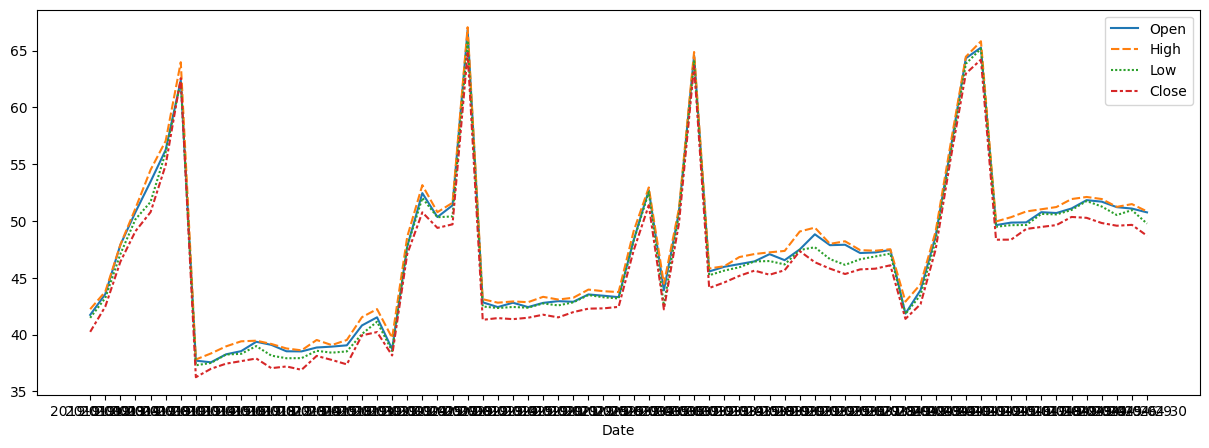

In [121]:
plt.figure(figsize=(15,5))
sns.lineplot(stock_daily.drop('Volume', axis=1));

#### Volume vs Close Price

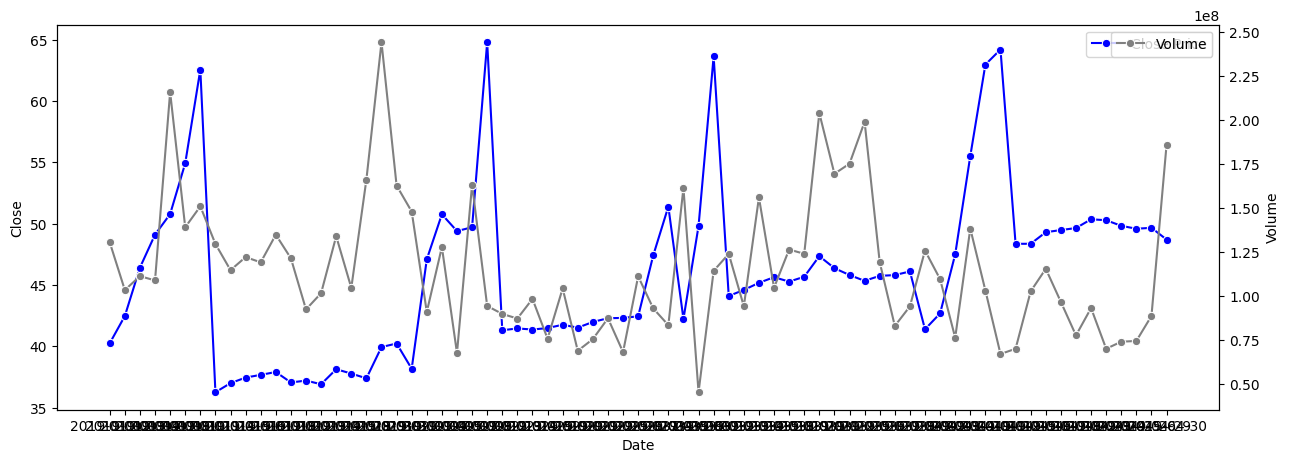

In [122]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(15,5))

# Lineplot on primary y-axis
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Close', ax=ax1, color='blue', marker='o', label='Close Price')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Lineplot on secondary y-axis
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Volume', ax=ax2, color='gray', marker='o', label='Volume')

ax1.legend(bbox_to_anchor=(1,1));

## **Text Preprocessing**

In [123]:
# creating a copy of the data
stock_data = stock.copy()

### **Removing special characters**

In [124]:
# defining a function to remove special characters
def remove_special_characters(text):
    # Defining the regex pattern to match non-alphanumeric characters
    pattern = '[^A-Za-z0-9]+'

    # Finding the specified pattern and replacing non-alphanumeric characters with a blank string
    new_text = ''.join(re.sub(pattern, ' ', text))

    return new_text

In [125]:
# Applying the function to remove special characters
stock['cleaned_text'] = stock['News'].apply(remove_special_characters)


In [126]:
# checking a couple of instances of cleaned data
stock.loc[0:5, ['News','cleaned_text']]

News  \
0   The tech sector experienced a significant dec...   
1   Apple lowered its fiscal Q1 revenue guidance ...   
2   Apple cut its fiscal first quarter revenue fo...   
3   This news article reports that yields on long...   
4   Apple's revenue warning led to a decline in U...   
5  Apple CEO Tim Cook discussed the company's Q1 ...   

                                        cleaned_text  
0   The tech sector experienced a significant dec...  
1   Apple lowered its fiscal Q1 revenue guidance ...  
2   Apple cut its fiscal first quarter revenue fo...  
3   This news article reports that yields on long...  
4   Apple s revenue warning led to a decline in U...  
5  Apple CEO Tim Cook discussed the company s Q1 ...

**Observations**

- We can observe that regex removed the special characters in the 4th,5th news, like **'** and retained the alphabets.

### **Lowercasing**

In [127]:
# changing the case of the text data to lower case
stock['cleaned_text'] = stock['cleaned_text'].str.lower()


In [128]:
# checking a couple of instances of cleaned data
stock.loc[0:3, ['News','cleaned_text']]

News  \
0   The tech sector experienced a significant dec...   
1   Apple lowered its fiscal Q1 revenue guidance ...   
2   Apple cut its fiscal first quarter revenue fo...   
3   This news article reports that yields on long...   

                                        cleaned_text  
0   the tech sector experienced a significant dec...  
1   apple lowered its fiscal q1 revenue guidance ...  
2   apple cut its fiscal first quarter revenue fo...  
3   this news article reports that yields on long...

**Observations**

- We can observe that all the text has now successfully been converted to lower case.

### **Removing extra whitespace**

In [129]:
# removing extra whitespaces from the text
stock['cleaned_text'] = stock['cleaned_text'].str.strip()


In [130]:
# checking a couple of instances of cleaned data
stock.loc[5:6, ['News','cleaned_text']]

News  \
5  Apple CEO Tim Cook discussed the company's Q1 ...   
6   Roku Inc has announced plans to offer premium...   

                                        cleaned_text  
5  apple ceo tim cook discussed the company s q1 ...  
6  roku inc has announced plans to offer premium ...

### **Removing stopwords**

* The idea with stop word removal is to exclude words that appear frequently throughout all the documents in the corpus.
* Pronouns and articles are typically categorized as stop words.
* The NLTK library has an in-built list of stop words and it can utilize that list to remove the stop words from a dataset.

In [131]:
# defining a function to remove stop words using the NLTK library
def remove_stopwords(text):
    # Split text into separate words
    words = text.split()

    # Removing English language stopwords
    new_text = ' '.join([word for word in words if word not in stopwords.words('english')])

    return new_text

In [132]:
# Applying the function to remove stop words using the NLTK library
stock['cleaned_text_without_stopwords'] = stock['cleaned_text'].apply(remove_stopwords)


In [133]:
# checking a couple of instances of cleaned data
stock.loc[0:3,['cleaned_text','cleaned_text_without_stopwords']]

cleaned_text  \
0  the tech sector experienced a significant decl...   
1  apple lowered its fiscal q1 revenue guidance t...   
2  apple cut its fiscal first quarter revenue for...   
3  this news article reports that yields on long ...   

                      cleaned_text_without_stopwords  
0  tech sector experienced significant decline af...  
1  apple lowered fiscal q1 revenue guidance 84 bi...  
2  apple cut fiscal first quarter revenue forecas...  
3  news article reports yields long dated u treas...

### **Stemming**

Stemming is a language processing method that chops off word endings to find the root or base form of words.

For example,

- Original Word: Jumping, Stemmed Word: Jump
- Original Word: Running, Stemmed Word: Run

The Porter Stemmer is one of the widely-used algorithms for stemming, and it shorten words to their root form by removing suffixes.

In [134]:
# Loading the Porter Stemmer
ps = PorterStemmer()

In [135]:
# defining a function to perform stemming
def apply_porter_stemmer(text):
    # Split text into separate words
    words = text.split()

    # Applying the Porter Stemmer on every word of a message and joining the stemmed words back into a single string
    new_text = ' '.join([ps.stem(word) for word in words])

    return new_text

In [136]:
# Applying the function to perform stemming
stock['final_cleaned_text'] = stock['cleaned_text_without_stopwords'].apply(apply_porter_stemmer)


In [137]:
# checking a couple of instances of cleaned data
stock.loc[0:2,['cleaned_text_without_stopwords','final_cleaned_text']]

cleaned_text_without_stopwords  \
0  tech sector experienced significant decline af...   
1  apple lowered fiscal q1 revenue guidance 84 bi...   
2  apple cut fiscal first quarter revenue forecas...   

                                  final_cleaned_text  
0  tech sector experienc signific declin aftermar...  
1  appl lower fiscal q1 revenu guidanc 84 billion...  
2  appl cut fiscal first quarter revenu forecast ...

## **Data Preprocessing**

In [ ]:
#print stastical detail of date column
stock['Date'].describe()

count                              349
mean     2019-02-16 16:05:30.085959936
min                2019-01-02 00:00:00
25%                2019-01-14 00:00:00
50%                2019-02-05 00:00:00
75%                2019-03-22 00:00:00
max                2019-04-30 00:00:00
Name: Date, dtype: object

In [ ]:
#Spliting the data into train,validate and test
X_train = stock[(stock['Date'] < '2019-04-01')].reset_index()    #Complete the code to select all rows where the 'Date' is before '2019-04-01'
X_val = stock[(stock['Date'] >= '2019-04-01') & (stock['Date'] < '2019-04-16')].reset_index()    #Complete the code to select all rows where the 'Date' is from '2019-04-01 to '2019-04-16' (excluded)
X_test = stock[stock['Date'] >= '2019-04-16'].reset_index()    #Complete the code to select all rows where the 'Date' is from '2019-04-16' till the end.

In [ ]:
# 'Label' column as the target variable
y_train = X_train['Label'].copy()
y_val = X_val['Label'].copy()
y_test = X_test['Label'].copy()

In [ ]:
#Complete the code to print the shape of X_train,X_val,X_test,y_train,y_val and y_test
print("Train data shape",X_train.shape)
print("Validation data shape",X_val.shape)
print("Test data shape ",X_test.shape)

print("Train label shape",y_train.shape)
print("Validation label shape",y_val.shape)
print("Test label shape ",y_test.shape)

Train data shape (286, 12)
Validation data shape (21, 12)
Test data shape  (42, 12)
Train label shape (286,)
Validation label shape (21,)
Test label shape  (42,)


**Observations**

* Trainig dataset has 81% of dataset.
* Validation dataset has 6% of dataset.
* Test dataset has 11% of dataset.


In [ ]:
X_train

index       Date                                               News  \
0        0 2019-01-02   The tech sector experienced a significant dec...   
1        1 2019-01-02   Apple lowered its fiscal Q1 revenue guidance ...   
2        2 2019-01-02   Apple cut its fiscal first quarter revenue fo...   
3        3 2019-01-02   This news article reports that yields on long...   
4        4 2019-01-02   Apple's revenue warning led to a decline in U...   
..     ...        ...                                                ...   
281    281 2019-03-27   U.S. stocks ended lower on Wednesday, with lo...   
282    282 2019-03-28   Sony Corp is shutting down its Beijing smartp...   
283    283 2019-03-28   Kazuo Hirai, Sony's chairman who led the comp...   
284    284 2019-03-29   Daimler, a German carmaker, has lodged a comp...   
285    285 2019-03-29   Apple announced the cancellation of its AirPo...   

          Open       High        Low      Close     Volume  Label  \
0    41.740002  42.244999  41.482498  40.246914  130672400     -1   
1    41.740002  42.244999  41.482498  40.246914  130672400     -1   
2    41.740002  42.244999  41.482498  40.246914  130672400     -1   
3    41.740002  42.244999  41.482498  40.246914  130672400     -1   
4    41.740002  42.244999  41.482498  40.246914  130672400     -1   
..         ...        ...        ...        ...        ...    ...   
281  47.187500  47.439999  46.637501  45.747482  119393600      0   
282  47.237499  47.389999  46.882500  45.808159   83121600     -1   
283  47.237499  47.389999  46.882500  45.808159   83121600      1   
284  47.457500  47.520000  47.134998  46.106716   94256000     -1   
285  47.457500  47.520000  47.134998  46.106716   94256000     -1   

                                          cleaned_text  \
0    the tech sector experienced a significant decl...   
1    apple lowered its fiscal q1 revenue guidance t...   
2    apple cut its fiscal first quarter revenue for...   
3    this news article reports that yields on long ...   
4    apple s revenue warning led to a decline in us...   
..                                                 ...   
281  u s stocks ended lower on wednesday with losse...   
282  sony corp is shutting down its beijing smartph...   
283  kazuo hirai sony s chairman who led the compan...   
284  daimler a german carmaker has lodged a complai...   
285  apple announced the cancellation of its airpow...   

                        cleaned_text_without_stopwords  \
0    tech sector experienced significant decline af...   
1    apple lowered fiscal q1 revenue guidance 84 bi...   
2    apple cut fiscal first quarter revenue forecas...   
3    news article reports yields long dated u treas...   
4    apple revenue warning led decline usd jpy pair...   
..                                                 ...   
281  u stocks ended lower wednesday losses healthca...   
282  sony corp shutting beijing smartphone plant du...   
283  kazuo hirai sony chairman led company revival ...   
284  daimler german carmaker lodged complaint nokia...   
285  apple announced cancellation airpower wireless...   

                                    final_cleaned_text  
0    tech sector experienc signific declin aftermar...  
1    appl lower fiscal q1 revenu guidanc 84 billion...  
2    appl cut fiscal first quarter revenu forecast ...  
3    news articl report yield long date u treasuri ...  
4    appl revenu warn led declin usd jpi pair gain ...  
..                                                 ...  
281  u stock end lower wednesday loss healthcar tec...  
282  soni corp shut beij smartphon plant due cost c...  
283  kazuo hirai soni chairman led compani reviv ye...  
284  daimler german carmak lodg complaint nokia eu ...  
285  appl announc cancel airpow wireless charg mat ...  

[286 rows x 12 columns]

## **Word Embeddings**

### Word2Vec

- `Word2Vec` is imported from Gensim library

- `Word2Vec` takes the following important parameters:
    1. `word_list`: List of all words in all documents
    2. `vector_size`: Determines the size of the word vectors
    2. `min_count`: It will ignore all the words with a total frequency lower than this.
    3. `Workers`: These are the number of threads to train the model.
    4. 'window': Size of context relative to target word.

In [ ]:
# Creating a list of all words in our data
words_list = [item.split(" ") for item in stock['final_cleaned_text'].values]

In [ ]:
# Creating an instance of Word2Vec
vec_size = 300
model_W2V = Word2Vec(words_list, vector_size = vec_size, min_count = 1, window=5, workers = 6)

In [ ]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary is 2580


Let's check out a few word embeddings obtained using the model.

In [ ]:
# Checking the word embedding of a random word
word = "stock"
model_W2V.wv[word]

array([ 2.81702867e-03,  7.68086407e-03, -1.68126018e-03,  5.75151574e-03,
       -5.05409320e-04, -1.13561442e-02,  8.38568062e-03,  1.83166508e-02,
        3.20163323e-03, -2.29159836e-03,  1.09589586e-04, -9.97979008e-03,
        1.12596806e-03,  2.60502356e-03, -1.01949684e-02, -8.00125301e-03,
        5.57932910e-03,  7.55677873e-04,  4.53754002e-03, -4.11387719e-03,
       -6.56350702e-03, -1.49470416e-03,  1.01245306e-02,  1.74206297e-03,
        1.12552959e-02,  1.04910007e-03, -1.20209614e-02, -2.82864925e-03,
       -5.84481284e-03, -8.46903026e-03,  5.05160075e-03, -2.33664505e-05,
        3.44158150e-04,  7.04587903e-04, -5.56705799e-03,  4.68071923e-03,
        1.11091218e-03, -1.37640340e-02, -1.26863481e-03, -3.03792791e-03,
       -1.59176136e-03, -1.15544768e-03,  2.78862217e-03, -8.01734626e-03,
        5.41171804e-03,  1.33999158e-02,  6.64606865e-04, -7.57118280e-04,
       -3.80799710e-03,  7.39459414e-03,  1.47827074e-03, -2.18435028e-03,
       -8.96805059e-03,  

In [ ]:
# Checking top 5 similar words to the word 'stock'
similar = model_W2V.wv.similar_by_word('stock', topn=5)
print(similar)

[('appl', 0.942367672920227), ('trade', 0.9329495429992676), ('compani', 0.9284650087356567), ('year', 0.9252082705497742), ('servic', 0.9224072098731995)]


In [ ]:
# Checking the word embedding of a random word
word = "fiscal"
model_W2V.wv[word]

array([ 1.40697241e-03,  3.09195439e-03, -1.39130140e-03,  1.17623701e-03,
        9.46649699e-04, -4.62411577e-03,  1.46282464e-03, -3.46054643e-04,
       -1.71468803e-03,  2.44192360e-03, -2.39552837e-03, -6.62268954e-04,
        1.00901676e-03, -2.06100149e-03, -4.20500617e-03, -4.33536945e-03,
        1.57301500e-03,  2.26016575e-03, -1.82573462e-03,  2.03139047e-04,
        1.89393002e-03,  4.26788931e-04,  3.02415038e-03,  2.23452412e-03,
        4.14718548e-03, -3.54914810e-04,  1.73694582e-03,  3.12443823e-03,
       -3.52841895e-03,  7.65746168e-04,  1.09700114e-03,  1.87964470e-03,
       -2.20290339e-03,  4.24832724e-05,  1.38497085e-03, -1.42130675e-03,
        3.22076539e-03,  5.51279110e-04,  1.49113231e-03,  1.56040664e-03,
        1.66480546e-03, -3.21381842e-03,  2.19214009e-04,  1.25851063e-03,
       -6.11090334e-04,  1.44013960e-04,  9.18114732e-04,  2.81915272e-04,
       -2.64854240e-03,  1.16932590e-03,  6.06236281e-04, -1.19721389e-03,
       -1.40307253e-04,  

In [ ]:
# Checking top 5 similar words to the word 'good'
similar = model_W2V.wv.similar_by_word('fiscal', topn=5)
print(similar)

[('slowdown', 0.40395665168762207), ('first', 0.4019532799720764), ('tax', 0.39867299795150757), ('index', 0.3953772485256195), ('impact', 0.3878379166126251)]


In [ ]:
# Retrieving the words present in the Word2Vec model's vocabulary
words = list(model_W2V.wv.key_to_index.keys())

# Retrieving word vectors for all the words present in the model's vocabulary
wvs = model_W2V.wv[words].tolist()

# Creating a dictionary of words and their corresponding vectors
word_vector_dict = dict(zip(words, wvs))

In [ ]:
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [ ]:
# creating a dataframe of the vectorized documents
start = time.time()

X_train_wv = pd.DataFrame(X_train["final_cleaned_text"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_val_wv = pd.DataFrame(X_val["final_cleaned_text"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_wv = pd.DataFrame(X_test["final_cleaned_text"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

end = time.time()
print('Time taken ', (end-start))

Time taken  0.6904916763305664


In [ ]:
print(X_train_wv.shape, X_val_wv.shape, X_test_wv.shape)

(286, 300) (21, 300) (42, 300)


In [ ]:
X_train_wv

Feature 0  Feature 1  Feature 2  Feature 3     Feature 4  Feature 5  \
0     0.000056   0.004772  -0.000783   0.002695  2.976343e-04  -0.006006   
1     0.000635   0.005684  -0.001471   0.003683 -4.551697e-04  -0.007480   
2     0.000277   0.004367  -0.000878   0.003010 -2.505989e-04  -0.006247   
3    -0.000652   0.005452  -0.001083   0.003396 -2.639325e-04  -0.006426   
4     0.000553   0.003485  -0.000553   0.002909 -2.369648e-04  -0.005315   
..         ...        ...        ...        ...           ...        ...   
281   0.000175   0.005681  -0.000399   0.002185  4.183652e-04  -0.006618   
282   0.000119   0.004017  -0.000433   0.002983 -5.636098e-04  -0.005523   
283   0.000484   0.002806  -0.000438   0.001420  1.772548e-04  -0.004061   
284   0.000150   0.002712  -0.000377   0.001782 -7.111439e-07  -0.003328   
285   0.000176   0.004787  -0.000575   0.002600 -9.059447e-04  -0.005697   

     Feature 6  Feature 7  Feature 8  Feature 9  ...  Feature 290  \
0     0.003400   0.009552   0.002203  -0.001141  ...    -0.000505   
1     0.003882   0.011010   0.002359  -0.000540  ...    -0.000277   
2     0.002576   0.009308   0.002139  -0.000596  ...    -0.000279   
3     0.003109   0.009810   0.001993  -0.001126  ...     0.000434   
4     0.002755   0.007667   0.001979  -0.000135  ...    -0.000858   
..         ...        ...        ...        ...  ...          ...   
281   0.004360   0.010259   0.002249  -0.000622  ...     0.000243   
282   0.002088   0.008617   0.001766  -0.000798  ...     0.000142   
283   0.001986   0.006155   0.001817  -0.000712  ...     0.000285   
284   0.001835   0.005451   0.001123  -0.000631  ...    -0.000559   
285   0.002439   0.009101   0.001718  -0.001653  ...    -0.000076   

     Feature 291  Feature 292  Feature 293  Feature 294  Feature 295  \
0       0.007336     0.005315     0.000838     0.005235     0.006128   
1       0.007561     0.006034     0.000817     0.005254     0.006741   
2       0.006579     0.005411     0.000489     0.004610     0.005949   
3       0.006239     0.004800     0.000518     0.004694     0.005560   
4       0.005633     0.004777     0.000858     0.004479     0.004916   
..           ...          ...          ...          ...          ...   
281     0.007507     0.005440     0.001190     0.004676     0.006318   
282     0.005531     0.004589     0.000136     0.003946     0.004990   
283     0.004285     0.003596     0.000837     0.002875     0.003431   
284     0.003878     0.002953     0.000588     0.002503     0.002703   
285     0.005871     0.005348     0.000772     0.003821     0.005481   

     Feature 296  Feature 297  Feature 298  Feature 299  
0       0.000207    -0.002788     0.003486    -0.000510  
1       0.000869    -0.003406     0.004262    -0.000383  
2       0.000814    -0.003670     0.003870    -0.000375  
3       0.000819    -0.002790     0.003098    -0.000123  
4       0.000552    -0.002615     0.003416    -0.000336  
..           ...          ...          ...          ...  
281     0.000976    -0.002943     0.005105     0.000147  
282     0.000476    -0.002827     0.003309    -0.000501  
283     0.000272    -0.001860     0.002645    -0.000595  
284     0.000554    -0.001705     0.001115    -0.000465  
285     0.000338    -0.003384     0.003862    -0.000867  

[286 rows x 300 columns]

### GloVe

In [ ]:
# Converting the Stanford GloVe model vector format to word2vec
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = '/content/drive/MyDrive/NLP Project/glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

(400000, 100)

In [ ]:
# load the Stanford GloVe model
filename = 'glove.6B.100d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [ ]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(glove_model.index_to_key))

Length of the vocabulary is 400000


Let's check out a few word embeddings.

In [ ]:
# Checking the word embedding of a random word
word = "stock"
glove_model[word]

array([ 8.6341e-01,  6.9648e-01,  4.5794e-02, -9.5708e-03, -2.5498e-01,
       -7.4666e-01, -2.2086e-01, -4.4615e-01, -1.0423e-01, -9.9931e-01,
        7.2550e-02,  4.5049e-01, -5.9912e-02, -5.7837e-01, -4.6540e-01,
        4.3429e-02, -5.0570e-01, -1.5442e-01,  9.8250e-01, -8.1571e-02,
        2.6523e-01, -2.3734e-01,  9.7675e-02,  5.8588e-01, -1.2948e-01,
       -6.8956e-01, -1.2811e-01, -5.2265e-02, -6.7719e-01,  3.0190e-02,
        1.8058e-01,  8.6121e-01, -8.3206e-01, -5.6887e-02, -2.9578e-01,
        4.7180e-01,  1.2811e+00, -2.5228e-01,  4.9557e-02, -7.2455e-01,
        6.6758e-01, -1.1091e+00, -2.0493e-01, -5.8669e-01, -2.5375e-03,
        8.2777e-01, -4.9102e-01, -2.6475e-01,  4.3015e-01, -2.0516e+00,
       -3.3208e-01,  5.1845e-02,  5.2646e-01,  8.7452e-01, -9.0237e-01,
       -1.7366e+00, -3.4727e-01,  1.6590e-01,  2.7727e+00,  6.5756e-02,
       -4.0363e-01,  3.8252e-01, -3.0787e-01,  5.9202e-01,  1.3468e-01,
       -3.3851e-01,  3.3646e-01,  2.0950e-01,  8.5905e-01,  5.18

In [ ]:
result = glove_model.most_similar("stock", topn=5)
print(result)

[('shares', 0.8525474667549133), ('stocks', 0.8309943079948425), ('market', 0.7991610765457153), ('exchange', 0.784952700138092), ('trading', 0.7632874846458435)]


In [ ]:
# Checking the word embedding of a random word
word = "economy"
glove_model[word]

array([-0.19382  ,  1.017    ,  1.076    ,  0.02954  , -0.39192  ,
       -1.3891   , -0.87873  , -0.63162  ,  0.9643   , -0.43035  ,
       -0.34868  ,  0.22736  , -0.40296  ,  0.15641  , -0.16813  ,
       -0.15343  , -0.15799  , -0.27612  ,  0.18088  , -0.28386  ,
        0.49847  ,  0.29864  ,  0.32353  ,  0.18108  , -0.59623  ,
       -0.54165  , -0.70019  , -0.64956  , -0.69063  ,  0.18084  ,
       -0.38581  ,  0.56086  , -0.40313  , -0.38777  , -0.70615  ,
        0.20657  ,  0.34171  , -0.23393  , -0.35882  , -0.2201   ,
       -0.76182  , -1.2047   ,  0.4339   ,  1.1656   ,  0.1836   ,
       -0.21601  ,  0.93198  , -0.059616 , -0.11624  , -1.3259   ,
       -0.79772  , -0.0074957, -0.0889   ,  1.4749   ,  0.31157  ,
       -2.2952   , -0.058351 ,  0.39353  ,  1.4983   ,  0.74023  ,
       -0.20109  ,  0.098124 , -0.73081  , -0.32294  ,  0.16703  ,
        0.87431  , -0.041624 , -0.51022  ,  1.0737   , -0.4257   ,
        1.0581   ,  0.19859  , -0.60087  , -0.33906  ,  0.6024

In [ ]:
# Retrieving the words present in the GloVe model's vocabulary
glove_words = glove_model.index_to_key

# Creating a dictionary of words and their corresponding vectors
glove_word_vector_dict = dict(zip(glove_model.index_to_key,list(glove_model.vectors)))

In [ ]:
vec_size=100

In [ ]:
def average_vectorizer_GloVe(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in glove_words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(glove_word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [ ]:
# creating a dataframe of the vectorized documents
start = time.time()

X_train_gl = pd.DataFrame(X_train['final_cleaned_text'].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)]) #Complete the code to apply GloVe on 'News' column
X_val_gl = pd.DataFrame(X_val['final_cleaned_text'].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)]) #Complete the code to apply GloVe on 'News' column
X_test_gl = pd.DataFrame(X_test['final_cleaned_text'].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)]) #Complete the code to apply GloVe on 'News' column

end = time.time()
print('Time taken ', (end-start))

Time taken  27.50004243850708


In [ ]:
print(X_train_gl.shape, X_val_gl.shape, X_test_gl.shape)

(286, 100) (21, 100) (42, 100)


### Sentence Transformer

#### Defining the model

In [ ]:
#Defining the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

#### Encoding the dataset

In [ ]:
# setting the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# encoding the dataset
start = time.time()

X_train_st = model.encode(X_train['News'].values, show_progress_bar=True, device=device)
X_val_st = model.encode(X_val['News'].values, show_progress_bar=True, device=device)
X_test_st = model.encode(X_test['News'].values, show_progress_bar=True, device=device)

end = time.time()
print("Time taken ",(end-start))

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Time taken  10.777348518371582


In [ ]:
print(X_train_st.shape, X_val_st.shape, X_test_st.shape)

(286, 384) (21, 384) (42, 384)


- Each news content has been converted to a 384-dimensional vector.

## **Sentiment Analysis**

### Model Evaluation Criterion

The **F1 score** is a valuable evaluation metric for stock market sentiment analysis because it balances precision and recall, two critical factors in this domain.
There might be more neutral or positive news than negative news. The F1 score helps by accounting for both precision (how accurate the model's positive predictions are) and recall (how well the model captures all positive instances), making it a robust measure

### Utility Functions

In [ ]:
def plot_confusion_matrix(model, predictors, target):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    cm = confusion_matrix(target, pred)  # Compute the confusion matrix.

    plt.figure(figsize=(5, 4))  # Create a new figure with a specified size.
    label_list = [0, 1,-1]  # Define the labels for the confusion matrix.
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
    # Plot the confusion matrix using a heatmap with annotations.

    plt.ylabel('Actual')  # Label for the y-axis.
    plt.xlabel('Predicted')  # Label for the x-axis.
    plt.title('Confusion Matrix')  # Title of the plot.
    plt.show()  # Display the plot.

In [ ]:
def model_performance_classification_sklearn(model, predictors, target):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    acc = accuracy_score(target, pred)  # Compute Accuracy.
    recall = recall_score(target, pred,average='weighted')  # Compute Recall.
    precision = precision_score(target, pred,average='weighted')  # Compute Precision.
    f1 = f1_score(target, pred,average='weighted')  # Compute F1-score.

    # Create a DataFrame to store the computed metrics.
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )

    return df_perf  # Return the DataFrame with the metrics.

### Base Model - Word2Vec

In [ ]:
# Building the model
rf_word2vec = RandomForestClassifier(random_state = 42)

# Fitting on train data
rf_word2vec.fit(X_train_wv, y_train)

RandomForestClassifier(random_state=42)

**Confusion Matrix**

**Train Data Set**

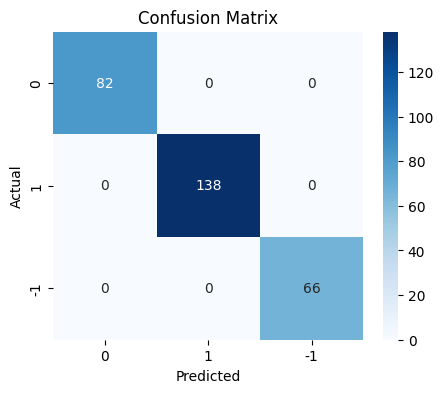

In [ ]:
plot_confusion_matrix(rf_word2vec,X_train_wv,y_train)

**Validation Data Set**

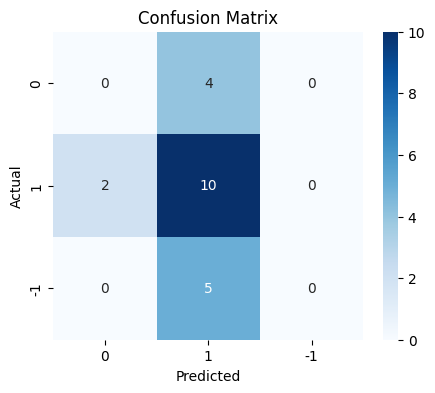

In [ ]:
plot_confusion_matrix(rf_word2vec,X_val_wv,y_val)

**Training Performance**

In [ ]:
#Calculating different metrics on training data
base_train_wv = model_performance_classification_sklearn(rf_word2vec,X_train_wv,y_train)
print("Training performance:\n", base_train_wv)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


**Validation Performance**

In [ ]:
#Calculating different metrics on validation data
base_val_wv = model_performance_classification_sklearn(rf_word2vec,X_val_wv,y_val)
print("Validation performance:\n",base_val_wv)

Validation performance:
    Accuracy   Recall  Precision        F1
0   0.47619  0.47619   0.300752  0.368664


### Base Model - Glove

In [ ]:
# Building the model
rf_glove = RandomForestClassifier(random_state = 42)

# Fitting on train data
rf_glove.fit(X_train_gl, y_train)

RandomForestClassifier(random_state=42)

**Confusion Matrix**

**Train Data Set**

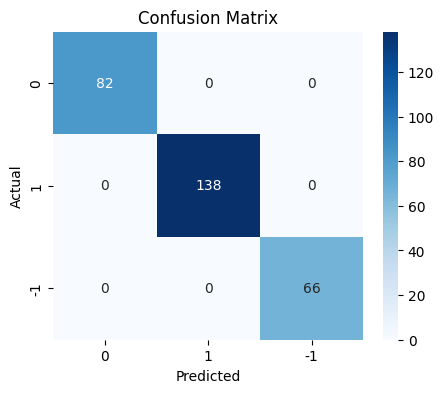

In [ ]:
plot_confusion_matrix(rf_glove,X_train_gl,y_train)

**Validation Data Set**

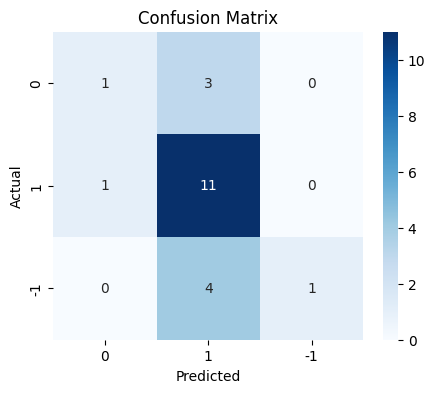

In [ ]:
plot_confusion_matrix(rf_glove,X_val_gl,y_val)

**Training Performance**

In [ ]:
#Calculating different metrics on training data
base_train_gl = model_performance_classification_sklearn(rf_glove,X_train_gl,y_train)
print("Training performance:\n", base_train_gl)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


**Validation Performance**

In [ ]:
#Calculating different metrics on validation data
base_val_gl = model_performance_classification_sklearn(rf_glove,X_val_gl,y_val)
print("Validation performance:\n",base_val_gl)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.619048  0.619048    0.68254  0.561905


### Base Model - Sentence Transformer

In [ ]:
# Building the model
rf_st = RandomForestClassifier(random_state = 42)

# Fitting on train data
rf_st.fit(X_train_st, y_train)

RandomForestClassifier(random_state=42)

**Confusion Matrix**

**Train Data Set**

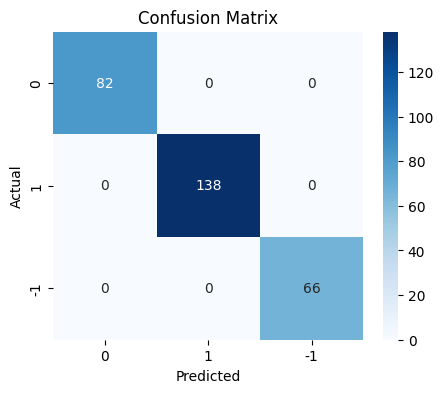

In [ ]:
plot_confusion_matrix(rf_st,X_train_st,y_train)

**Validation Data Set**

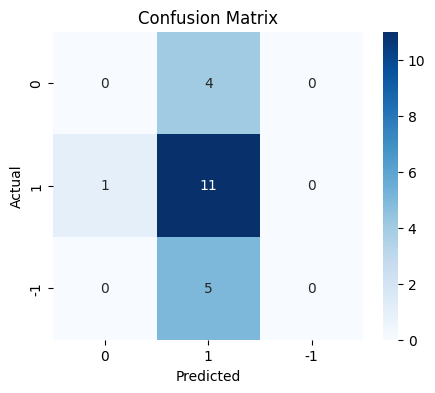

In [ ]:
plot_confusion_matrix(rf_st,X_val_st,y_val)

**Training Performance**

In [ ]:
#Calculating different metrics on training data
base_train_st = model_performance_classification_sklearn(rf_st,X_train_st,y_train)
print("Training performance:\n", base_train_st)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


**Validation Performance**

In [ ]:
#Calculating different metrics on validation data
base_val_st = model_performance_classification_sklearn(rf_st,X_val_st,y_val)
print("Validation performance:\n",base_val_st)

Validation performance:
    Accuracy   Recall  Precision        F1
0   0.52381  0.52381   0.314286  0.392857


### Tuned Model - Word2Vec

In [ ]:
start = time.time()

# Choose the type of classifier.

tuned_wv =RandomForestClassifier(class_weight= "balanced",random_state=1,bootstrap=True)
parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_wv, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_wv, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_wv = grid_obj.best_estimator_

Time taken  225.58313965797424


In [ ]:
# Fit the best algorithm to the data.
tuned_wv.fit(X_train_wv, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3,
                       min_samples_split=5, random_state=1)

**Confusion Matrix**

**Train Data Set**

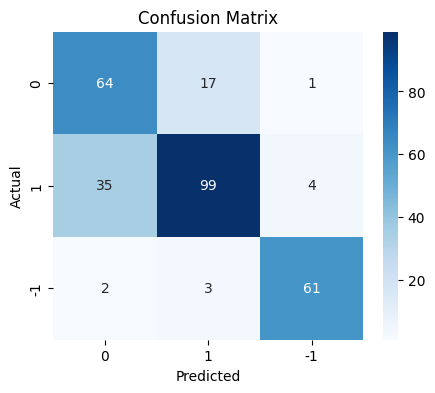

In [ ]:
plot_confusion_matrix(tuned_wv,X_train_wv,y_train)

**Validation Data Set**

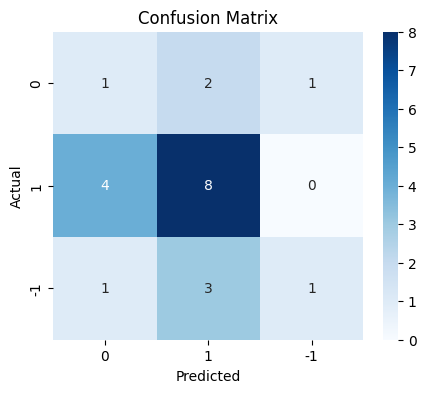

In [ ]:
plot_confusion_matrix(tuned_wv,X_val_wv,y_val)

**Training Performance**

In [ ]:
#Calculating different metrics on training data
tuned_train_wv = model_performance_classification_sklearn(tuned_wv,X_train_wv,y_train)
print("Training performance:\n", tuned_train_wv)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.783217  0.783217   0.796389  0.785574


**Validation Performance**

In [ ]:
#Calculating different metrics on validation data
tuned_val_wv = model_performance_classification_sklearn(tuned_wv,X_val_wv,y_val)
print("Validation performance:\n",tuned_val_wv)

Validation performance:
    Accuracy   Recall  Precision        F1
0   0.47619  0.47619   0.502442  0.471837


### Tuned Model - Glove

In [ ]:
start = time.time()

# Choose the type of classifier.

tuned_gl =RandomForestClassifier(class_weight= "balanced",random_state=1,bootstrap=True)
parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_gl, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_gl, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_gl = grid_obj.best_estimator_

Time taken  100.69691228866577


In [ ]:
# Fit the best algorithm to the data.
tuned_gl.fit(X_train_gl, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=0.2,
                       min_samples_split=9, random_state=1)

**Confusion Matrix**

**Train Data Set**

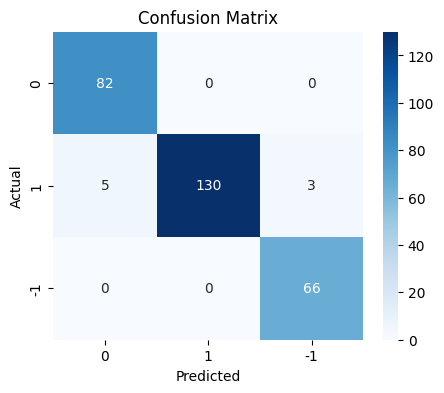

In [ ]:
plot_confusion_matrix(tuned_gl,X_train_gl,y_train)

**Validation Data Set**

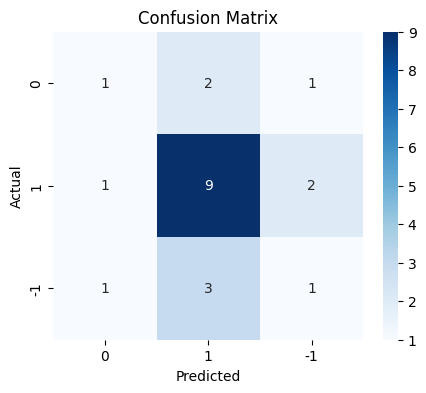

In [ ]:
plot_confusion_matrix(tuned_gl,X_val_gl,y_val)

**Training Performance**

In [ ]:
#Calculating different metrics on training data
tuned_train_gl = model_performance_classification_sklearn(tuned_gl,X_train_gl,y_train)
print("Training performance:\n", tuned_train_gl)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.972028  0.972028   0.973489  0.971986


**Validation Performance**

In [ ]:
#Calculating different metrics on validation data
tuned_val_gl = model_performance_classification_sklearn(tuned_gl,X_val_gl,y_val)
print("Validation performance:\n",tuned_val_gl)

Validation performance:
    Accuracy   Recall  Precision        F1
0   0.52381  0.52381   0.490363  0.502936


### Tuned Model - Sentence Transformer

In [ ]:
start = time.time()

# Choose the type of classifier.

tuned_st =RandomForestClassifier(class_weight= "balanced",random_state=1,bootstrap=True)
parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_st, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_st, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_st = grid_obj.best_estimator_

Time taken  272.7812888622284


In [ ]:
# Fit the best algorithm to the data.
tuned_st.fit(X_train_st, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=4,
                       min_samples_split=7, random_state=1)

**Confusion Matrix**

**Train Data Set**

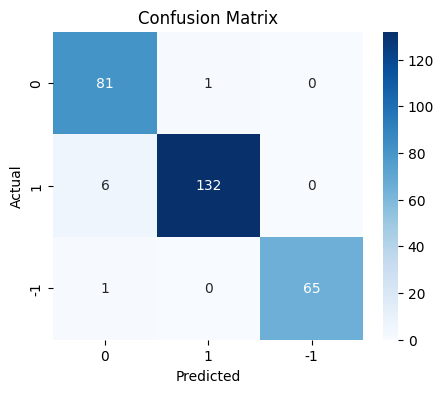

In [ ]:
plot_confusion_matrix(tuned_st,X_train_st,y_train)

**Validation Data Set**

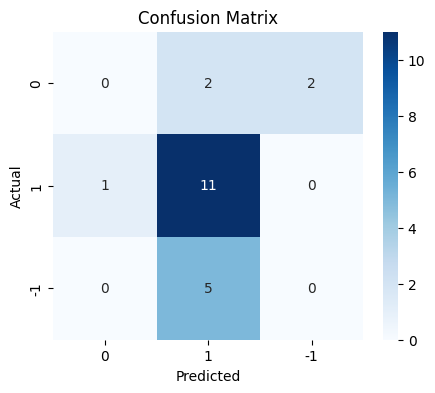

In [ ]:
plot_confusion_matrix(tuned_st,X_val_st,y_val)

**Training Performance**

In [ ]:
#Calculating different metrics on training data
tuned_train_st = model_performance_classification_sklearn(tuned_st,X_train_st,y_train)
print("Training performance:\n", tuned_train_st)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.972028  0.972028   0.973565  0.972282


**Validation Performance**

In [ ]:
#Calculating different metrics on validation data
tuned_val_st = model_performance_classification_sklearn(tuned_st,X_val_st,y_val)
print("Validation performance:\n",tuned_val_st)

Validation performance:
    Accuracy   Recall  Precision        F1
0   0.52381  0.52381   0.349206  0.419048


### Model Performance Summary and Final Model Selection

In [ ]:
#training performance comparison

models_train_comp_df = pd.concat(
    [base_train_wv.T,
     base_train_gl.T,
     base_train_st.T,
     tuned_train_wv.T,
     tuned_train_gl.T,
     tuned_train_st.T,
    ],axis=1
)

models_train_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


Base Model (Word2Vec)  Base Model (GloVe)  \
Accuracy                     1.0                 1.0   
Recall                       1.0                 1.0   
Precision                    1.0                 1.0   
F1                           1.0                 1.0   

           Base Model (Sentence Transformer)  Tuned Model (Word2Vec)  \
Accuracy                                 1.0                0.783217   
Recall                                   1.0                0.783217   
Precision                                1.0                0.796389   
F1                                       1.0                0.785574   

           Tuned Model (GloVe)  Tuned Model (Sentence Transformer)  
Accuracy              0.972028                            0.972028  
Recall                0.972028                            0.972028  
Precision             0.973489                            0.973565  
F1                    0.971986                            0.972282

In [ ]:
#validation performance comparison

models_val_comp_df = pd.concat(
    [base_val_wv.T,
     base_val_gl.T,
     base_val_st.T,
     tuned_val_wv.T,
     tuned_val_gl.T,
     tuned_val_st.T,
     ],axis=1
)

models_val_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


Base Model (Word2Vec)  Base Model (GloVe)  \
Accuracy                0.476190            0.619048   
Recall                  0.476190            0.619048   
Precision               0.300752            0.682540   
F1                      0.368664            0.561905   

           Base Model (Sentence Transformer)  Tuned Model (Word2Vec)  \
Accuracy                            0.523810                0.476190   
Recall                              0.523810                0.476190   
Precision                           0.314286                0.502442   
F1                                  0.392857                0.471837   

           Tuned Model (GloVe)  Tuned Model (Sentence Transformer)  
Accuracy              0.523810                            0.523810  
Recall                0.523810                            0.523810  
Precision             0.490363                            0.349206  
F1                    0.502936                            0.419048

* From the above two metric tables, we can observe that "Tuned Model (Word2Vec)" with Grid Search model is giving somewhat generalized results as compared to other model ,although all models are overfitting.From all the above we would select "Tuned Model (Word2Vec)"

### Model Performance Check on Test Data

**Confusion Matrix**

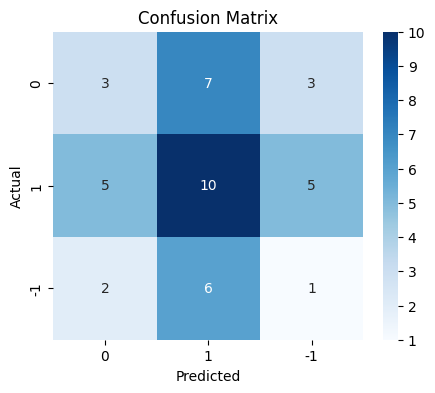

In [ ]:
plot_confusion_matrix(tuned_wv,X_test_wv,y_test)

In [ ]:
#Calculating different metrics on training data
tuned_train_wv = model_performance_classification_sklearn(tuned_wv,X_test_wv,y_test)
print("Training performance:\n", tuned_train_wv)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.333333  0.333333   0.323706  0.326039


## **Weekly News Summarization**

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

In [156]:
pip install --upgrade build setuptools wheel

In [157]:
!set LLAMA_CUBLAS=1
!set CMAKE_ARGS=-DLLAMA_CUBLAS=on
!set FORCE_CMAKE=1

In [158]:
#Install llama-cpp-python, cuda-enabled package
!python -m pip install llama-cpp-python==0.2.7 --prefer-binary --extra-index-url=https://jllllll.github.io/llama-cpp-python-cuBLAS-wheels/AVX2/cu122

Looking in indexes: https://pypi.org/simple, https://jllllll.github.io/llama-cpp-python-cuBLAS-wheels/AVX2/cu122


In [159]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

#### Loading the data

In [160]:
# loading data into a pandas dataframe
stock_news = pd.read_csv("/content/drive/MyDrive/NLP Project/stock_news.csv")

In [161]:
data = stock_news.copy()

#### Loading the model

In [ ]:
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q6_K.gguf"


model_path = hf_hub_download(
    repo_id=model_name_or_path,
    filename=model_basename
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


mistral-7b-instruct-v0.2.Q6_K.gguf:   0%|          | 0.00/5.94G [00:00<?, ?B/s]

**Llama Model**

In [ ]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGUF"
model_basename = "llama-2-13b-chat.Q5_K_M.gguf" # the model is in gguf format

In [ ]:
# Using hf_hub_download to download a model from the Hugging Face model hub
# The repo_id parameter specifies the model name or path in the Hugging Face repository
# The filename parameter specifies the name of the file to download
model_path = hf_hub_download(
    repo_id=model_name_or_path,
    filename=model_basename
)

llama-2-13b-chat.Q5_K_M.gguf:   0%|          | 0.00/9.23G [00:00<?, ?B/s]

In [ ]:
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2,  # CPU cores
    n_batch=512,  # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    # n_gpu_layers=43,  # uncomment and change this value based on GPU VRAM pool.
    n_ctx=4096,  # Context window
)

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 


In [ ]:
llm = Llama(
    model_path=model_path, # Path to the model
    n_gpu_layers=100, #Number of layers transferred to GPU
    n_ctx=4500, #Context window
)

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 


## **Text Preprocessing**

### **Removing special characters**

In [162]:
# defining a function to remove special characters
def remove_special_characters(text):
    # Defining the regex pattern to match non-alphanumeric characters
    pattern = '[^A-Za-z0-9]+'

    # Finding the specified pattern and replacing non-alphanumeric characters with a blank string
    new_text = ''.join(re.sub(pattern, ' ', text))

    return new_text

In [163]:
# Applying the function to remove special characters
data['cleaned_text'] = data['News'].apply(remove_special_characters)


In [164]:
# checking a couple of instances of cleaned data
data.loc[0:5, ['News','cleaned_text']]

News  \
0   The tech sector experienced a significant dec...   
1   Apple lowered its fiscal Q1 revenue guidance ...   
2   Apple cut its fiscal first quarter revenue fo...   
3   This news article reports that yields on long...   
4   Apple's revenue warning led to a decline in U...   
5  Apple CEO Tim Cook discussed the company's Q1 ...   

                                        cleaned_text  
0   The tech sector experienced a significant dec...  
1   Apple lowered its fiscal Q1 revenue guidance ...  
2   Apple cut its fiscal first quarter revenue fo...  
3   This news article reports that yields on long...  
4   Apple s revenue warning led to a decline in U...  
5  Apple CEO Tim Cook discussed the company s Q1 ...

**Observations**

- We can observe that regex removed the special characters in the 4th,5th news, like **'** and retained the alphabets.

### **Lowercasing**

In [165]:
# changing the case of the text data to lower case
data['cleaned_text'] = data['cleaned_text'].str.lower()


In [166]:
# checking a couple of instances of cleaned data
data.loc[0:3, ['News','cleaned_text']]

News  \
0   The tech sector experienced a significant dec...   
1   Apple lowered its fiscal Q1 revenue guidance ...   
2   Apple cut its fiscal first quarter revenue fo...   
3   This news article reports that yields on long...   

                                        cleaned_text  
0   the tech sector experienced a significant dec...  
1   apple lowered its fiscal q1 revenue guidance ...  
2   apple cut its fiscal first quarter revenue fo...  
3   this news article reports that yields on long...

**Observations**

- We can observe that all the text has now successfully been converted to lower case.

### **Removing extra whitespace**

In [167]:
# removing extra whitespaces from the text
data['cleaned_text'] = data['cleaned_text'].str.strip()


In [168]:
# checking a couple of instances of cleaned data
data.loc[5:6, ['News','cleaned_text']]

News  \
5  Apple CEO Tim Cook discussed the company's Q1 ...   
6   Roku Inc has announced plans to offer premium...   

                                        cleaned_text  
5  apple ceo tim cook discussed the company s q1 ...  
6  roku inc has announced plans to offer premium ...

### **Stemming**

Stemming is a language processing method that chops off word endings to find the root or base form of words.

For example,

- Original Word: Jumping, Stemmed Word: Jump
- Original Word: Running, Stemmed Word: Run

The Porter Stemmer is one of the widely-used algorithms for stemming, and it shorten words to their root form by removing suffixes.

In [169]:
# Loading the Porter Stemmer
ps = PorterStemmer()

In [170]:
# defining a function to perform stemming
def apply_porter_stemmer(text):
    # Split text into separate words
    words = text.split()

    # Applying the Porter Stemmer on every word of a message and joining the stemmed words back into a single string
    new_text = ' '.join([ps.stem(word) for word in words])

    return new_text

In [175]:
# Applying the function to perform stemming
data['final_cleaned_text'] = data['cleaned_text'].apply(apply_porter_stemmer)


#### Aggregating the data weekly

In [176]:
data["Date"] = pd.to_datetime(data['Date'])  # Convert the 'Date' column to datetime format.

In [177]:
# Group the data by week using the 'Date' column.
weekly_grouped = data.groupby(pd.Grouper(key='Date', freq='W'))

In [178]:
weekly_grouped = weekly_grouped.agg(
    {
        'final_cleaned_text': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

(18, 2)


In [179]:
weekly_grouped

Date                                 final_cleaned_text
0  2019-01-06  the tech sector experienc a signific declin in...
1  2019-01-13  sprint and samsung plan to releas 5g smartphon...
2  2019-01-20  the u s stock market declin on monday as conce...
3  2019-01-27  the swiss nation bank snb governor andrea maec...
4  2019-02-03  caterpillar inc report lower than expect fourt...
5  2019-02-10  the dow jone industri averag s p 500 and nasda...
6  2019-02-17  thi week the european union s second highest c...
7  2019-02-24  thi news articl discuss progress toward gender...
8  2019-03-03  the dow jone industri averag and other major i...
9  2019-03-10  spotifi the world s largest paid music stream ...
10 2019-03-17  the unit state oppos franc s digit servic tax ...
11 2019-03-24  facebook s stock price drop more than 3 on mon...
12 2019-03-31  thi news articl report that the s p 500 index ...
13 2019-04-07  appl and other consum brand includ lvmh s loui...
14 2019-04-14  in march mobil phone shipment to china drop by...
15 2019-04-21  the chairman of taiwan s foxconn terri gou pla...
16 2019-04-28  taiwan s export order continu to declin for th...
17 2019-05-05  spotifi report better than expect q1 revenu gr...

In [144]:
# creating a copy of the data
data_1 = weekly_grouped.copy()

In [180]:
#rename column name after text cleaning
data_1 = data_1.rename(columns={'final_cleaned_text': 'News'})

In [181]:
data_1.head()

Date                                               News  \
0 2019-01-06  tech sector experienc signific declin aftermar...   
1 2019-01-13  sprint samsung plan releas 5g smartphon nine u...   
2 2019-01-20  u stock market declin monday concern global ec...   
3 2019-01-27  swiss nation bank snb governor andrea maechler...   
4 2019-02-03  caterpillar inc report lower expect fourth qua...   

                                          Key Events  \
0  \nHere are the three positive events and three...   
1  \nHere are the positive and negative events fr...   
2   Sure! Here are the positive and negative even...   
3   Sure! Here are the positive and negative even...   
4  \nHere are the positive and negative events fr...   

                               model_response_parsed  
0                                                 {}  
1  {'positive_events': ['Austrian tech firm to lo...  
2  {'positive_events': ['Netflix raises prices fo...  
3  {'positive_events': ['IBM stock price increase...  
4  {'positive_events': ['Apple's stock rose despi...

#### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

For the project, we need to define the prompt to be fed to the LLM to help it understand the task to perform. The following should be the components of the prompt:

1. **Role**: Specifies the role the LLM will be taking up to perform the specified task, along with any specific details regarding the role

  - **Example**: `You are an expert data analyst specializing in news content analysis.`

2. **Task**: Specifies the task to be performed and outlines what needs to be accomplished, clearly defining the objective

  - **Example**: `Analyze the provided news headline and return the main topics contained within it.`

3. **Instructions**: Provides detailed guidelines on how to perform the task, which includes steps, rules, and criteria to ensure the task is executed correctly

  - **Example**:

```
Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.
```

4. **Output Format**: Specifies the format in which the final response should be structured, ensuring consistency and clarity in the generated output

  - **Example**: `Return the output in JSON format with keys as the topic number and values as the actual topic.`

**Full Prompt Example**:

```
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with keys as the topic number and values as the actual topic.
```

**Sample Output**:

`{"1": "Politics", "2": "Economy", "3": "Health" }`

##### Utility Functions

In [182]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

In [145]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# Download NLTK stopwords
nltk.download('punkt')
nltk.download('stopwords')

# Define stopwords
stop_words = set(stopwords.words('english'))

# Function to clean content
def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters (keeping only alphanumeric and spaces)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    text=re.sub(r'"', '', text)
    text=re.sub(f"[{re.escape(string.punctuation)}]", '', text)
    text=re.sub(r'[@#!]', '', text)
    return text



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### Defining the response function

In [183]:
#Defining the response function
def response_mistral_1(prompt, news):
    model_output = llm(
      f"""
      [INST]
      {prompt}
      News Articles: {news}
      [/INST]
      """,
      max_tokens=1024, #Complete the code to set the maximum number of tokens the model should generate for this task.
      temperature=0.01, #Complete the code to set the value for temperature.
      top_p=0.88, #Complete the code to set the value for top_p
      top_k=50, #Complete the code to set the value for top_k
      echo=False,
    )

    final_output = model_output["choices"][0]["text"]

    return final_output

##### Checking the model output on a sample

**Note**: Use this section to test out the prompt with one instance before using it for the entire weekly data.

In [ ]:
news1 = data_1.loc[6, 'News']

In [ ]:
print(len(news1.split(' ')))
news1

876


" This week, the European Union's second highest court will rule on a Belgian tax break that reportedly benefited over 35 large companies, including Apple, Starbucks, Fiat Chrysler, and others. The European Commission ordered Belgium to recover around €790 million from these firms for allegedly providing an unfair advantage ||  Akamai Technologies reported stronger than projected earnings, driven by increased demand for its cybersecurity and media content delivery services. Revenue from its cloud security business rose 36% to $185 million, and the security unit is expected to exceed $1 billion in annual revenue soon. The company's media and carrier division saw an ||  Apple is facing resistance from several publications over its proposed news subscription service, which could be priced around $10 per month. The company plans to keep about half of the revenue but has not yet finalized the price. Apple's transaction fee of 30 percent for software developers in the App Store may be a conc

In [28]:
#Complete the code to define the prompt for this task
prompt = '''
You are an expert data analyst specializing in news content analysis.
Identify and list 3 positive event and 3 negative event from the news content.
Only select clear ,distinct event and format the output in the following JSON format:
{
  "positive_events": [
    "First positive event",
    "Second positive event",
    "Third positive event"
  ],
  "negative_events": [
    "First negative event",
    "Second negative event",
    "Third negative event"
  ]
}
 '''

In [ ]:
%%time
summary = response_mistral_1(prompt, news1)
print(summary)

Llama.generate: prefix-match hit


 Sure! Here is the list of positive and negative events from the news articles you provided:

Positive Events:

1. Akamai Technologies reported stronger than projected earnings, driven by increased demand for its cybersecurity and media content delivery services.
2. Apple's media and carrier division saw an increase in revenue.
3. The U.K. government's report recommending greater regulation of tech companies could lead to fair competition and better treatment of publishers.

Negative Events:

1. The European Commission ordered Belgium to recover around €790 million from large companies, including Apple, Starbucks, Fiat Chrysler, and others, for allegedly providing an unfair advantage.
2. Apple's transaction fee of 30 percent for software developers in the App Store may be a concern for publishers.
3. The EU General Court dealt a potential setback to the European Commission's campaign against corporate tax avoidance by annulling an order for Belgian tax break schemes worth about 700 mil

##### Checking the model output on the weekly data

In [92]:
#%%time
#data_1['CleanText'] = data_1['News'].progress_apply(lambda x: clean_text(x))

100%|██████████| 18/18 [00:00<00:00, 1147.40it/s]

CPU times: user 19.1 ms, sys: 0 ns, total: 19.1 ms
Wall time: 21 ms


In [93]:
#data_1['CleanText'].head()

0    the tech sector experienced a significant decl...
1    sprint and samsung plan to release 5g smartpho...
2    the us stock market declined on monday as conc...
3    the swiss national bank snb governor andrea ma...
4    caterpillar inc reported lowerthanexpected fou...
Name: CleanText, dtype: object

In [184]:
%%time
data_1['Key Events'] = data_1['News'].progress_apply(lambda x: response_mistral_1(prompt,x))

100%|██████████| 18/18 [08:21<00:00, 27.87s/it]

CPU times: user 6min 47s, sys: 1min 13s, total: 8min
Wall time: 8min 21s


In [186]:
data_1['Key Events'].head(6)

0    \nHere are the three positive events and three...
1    \nHere are the positive and negative events fr...
2     Sure! Here are the positive and negative even...
3     Sure! Here are the positive and negative even...
4    \nHere are the positive and negative events fr...
5    \nHere are the positive and negative events fr...
Name: Key Events, dtype: object

##### Formatting the model output

In [187]:
data_1['model_response_parsed'] = data_1['Key Events'].apply(extract_json_data)


Here are the three positive events and three negative events from the news content you provided:

Positive Events:

1. Amazon sold over 100 million devices with Alexa digital assistant, according to a company statement.
2. European stock markets, particularly in the sector sensitive to trade wars, rallied after carmaker and banking stocks led gains due to copper price recovery.
3. The supreme court reviewed Broadcom's appeal in a shareholder lawsuit from 2015, which could extend beyond Broadcom's suit against Emulex.

Negative Events:

1. Apple lowered its quarterly revenue forecast for the first time in 15 years due to weak iPhone sales, particularly in China.
2. Delta Air Lines reported lower-than-expected fourth-quarter unit revenue growth, citing weaker demand and increased competition.
3. Oil prices fell on Thursday as investor sentiment remained affected by the China economic slowdown and trade turmoil, with US WTI crude oil falling 2.1% and Brent crude oil dropping 1.2%.
Error p

In [188]:
data_1.head(10)

Date                                               News  \
0 2019-01-06  tech sector experienc signific declin aftermar...   
1 2019-01-13  sprint samsung plan releas 5g smartphon nine u...   
2 2019-01-20  u stock market declin monday concern global ec...   
3 2019-01-27  swiss nation bank snb governor andrea maechler...   
4 2019-02-03  caterpillar inc report lower expect fourth qua...   
5 2019-02-10  dow jone industri averag p 500 nasdaq composit...   
6 2019-02-17  week european union second highest court rule ...   
7 2019-02-24  news articl discuss progress toward gender equ...   
8 2019-03-03  dow jone industri averag major index post gain...   
9 2019-03-10  spotifi world largest paid music stream platfo...   

                                          Key Events  \
0  \nHere are the three positive events and three...   
1  \nHere are the positive and negative events fr...   
2   Sure! Here are the positive and negative even...   
3   Sure! Here are the positive and negative even...   
4  \nHere are the positive and negative events fr...   
5  \nHere are the positive and negative events fr...   
6  \nHere are the positive and negative events fr...   
7  \nHere are the three positive events and three...   
8  \nHere are the three positive events and three...   
9  \nHere are the positive and negative events fr...   

                               model_response_parsed  
0                                                 {}  
1  {'positive_events': ['Austrian tech firm to lo...  
2  {'positive_events': ['Netflix raises prices fo...  
3  {'positive_events': ['IBM stock price increase...  
4  {'positive_events': ['Apple's stock rose despi...  
5  {'positive_events': ['Apple's retail chief Ang...  
6  {'positive_events': ['Apple plans to launch a ...  
7  {'positive_events': ['Apple may launch a co-br...  
8  {'positive_events': ['Huawei defends its posit...  
9  {'positive_events': ['Tesla's bullish thesis r...

In [189]:
model_response_parsed = pd.json_normalize(data_1['model_response_parsed'])


In [190]:
final_output = pd.concat([data_1.reset_index(drop=True),model_response_parsed],axis=1)
final_output.drop(['Key Events','model_response_parsed'], axis=1, inplace=True)
final_output.columns = ['Week End Date', 'News', 'Week Positive Events', 'Week Negative Events']

final_output.head()

Week End Date                                               News  \
0    2019-01-06  tech sector experienc signific declin aftermar...   
1    2019-01-13  sprint samsung plan releas 5g smartphon nine u...   
2    2019-01-20  u stock market declin monday concern global ec...   
3    2019-01-27  swiss nation bank snb governor andrea maechler...   
4    2019-02-03  caterpillar inc report lower expect fourth qua...   

                                Week Positive Events  \
0                                                NaN   
1  [Austrian tech firm to lower revenues growth f...   
2  [Netflix raises prices for its standard and pr...   
3  [IBM stock price increases hour due to better ...   
4  [Apple's stock rose despite rare revenue decli...   

                                Week Negative Events  
0                                                NaN  
1  [Apple's stock price cut due to weak demand fo...  
2  [Apple stock declines after the company misses...  
3  [The Swiss National Bank (SNB) governor, Andre...  
4  [Caterpillar Inc. reported lower expectations ...

In [191]:
final_output.loc[1,'News']

'sprint samsung plan releas 5g smartphon nine u citi summer atlanta chicago dalla houston kansa citi lo angel new york citi phoenix washington c initi locat rival verizon also announc similar plan first half 20 || am austrian tech compani list switzerland major supplier appl develop light infrar proxim sensor place behind smartphon screen allow larger display area reduc requir space sensor am provid optic sensor 3d facial recognit featur appl || deutsch bank upgrad vivendi univers music group valuat 20 billion 29 billion surpass market cap vivendi 28 3 billion bank anticip music stream revenu reach 21 billion 2023 identifi potenti suitor || amazon stock predict surg 20 end year accord new report pivot research senior analyst brian wieser initi coverag stock buy rate year end price target 1 920 growth potenti amazon lie primarili || am austrian sensor specialist partner chines softwar maker face develop new 3d facial recognit featur smartphon move come am aim reduc depend appl boost bat

In [ ]:
news1 = data_1.loc[6, 'News']

## **Conclusions and Recommendations**

**Conclusion**
- We used an Mistral to do multiple tasks, one stage at a time
    1. We first assigned the Mistral model role of data analyst specializing in news content analysis.
    2. We then group the news into week news
    3. Next, we ask the model to understand each news deeply and figure out positive and negative events from full week news.
    4. Next,for all the week news we ask model to list out 3 positive and 3 negative event based on the impact it has on stock market
    5. Finally, we also got a response we can use to understand stock market sentiments


**Recommendation**

* Mistral might have a more rigid structure that could limit adaptability.so we can use LLama model.
* Mistral is trained on less diverse or lower-quality data compared to LLaMA, it may exhibit limitations in understanding nuanced language or less common scenarios.
*Update Prompt to get more better result but due to more computational resources required we have to limit the prompt capability.


-




<font size=6 color='blue'>Power Ahead</font>
___